In [1]:
import networkx as nx # version 2.2
import matplotlib.pyplot as plt
import re
import cvxpy as cp
import operator #to sort elements in a list of tuples
import itertools
import math
import numpy as np
import os
import sys
import time

import Init_NetRate as Init
import Cascade_generation_functions_NetRate as Gen
import CVX_functions as cvx

In [18]:
network_file_name = "./Graph_test_SG.txt"
cascade_file_name = "./Cascade_test_SG.txt" # can not use the graphs generated by NetInf (for now, there is some bugs with the time limit)
window = 10 # Time limit of the observation of a cascade
beta = 1 # probability of an edge transmitting the disease 
model = 0 # choose between exp and power law (for now only exp is implemented)
eps = 0.0005 #Lower bound on the value of alpha (we do not want to have alpha = 0 since we have some division and log of alpha)
alpha_init = 0.01 # Initilization value of alpha for the SGD
min_alpha = 0.05 # Value of alpha at which we consider it as an edge in the network
gamma = 0.0005 # learning rate
K = 50000 #number of itterations
max_alpha = 10 #upper bound of alpha. Otherwise it may degenerate

In [3]:
'''
Evaluate the objective function given a cascade and the alphas

Input :
    -alpha_mat : matrix of size |V|*|V| containing all the alpha_i,j
    -cascade_graph : Directed graph object (DAG), of a cascade
    -G_star : Directed graph containing only the nodes
    -window : int representing the time limit until which we observe a cascade propagation
Output :
    -obj : value of the objective funtion restricted to one cascade
'''
def Objective_function(alpha_mat,cascade_graph_c,G_star,window,eps):
    sum_psi1 = 0
    sum_psi2 = 0
    sum_psi3 = 0
    for i in cascade_graph_c.nodes():
        sum_psi3_tmp = 0
        t_i = cascade_graph_c.nodes[i]["time"]
        for m in G_star.nodes():
            if alpha_mat[i,m]==eps :
                alpha_mat[i,m] = 0
            if alpha_mat[m,i]==eps:
                alpha_mat[m,i] = 0
            if m not in cascade_graph_c.nodes():
                sum_psi1 += -alpha_mat[i,m]*(window-t_i)
            elif (m,i) in cascade_graph_c.edges():
                t_m = cascade_graph_c.nodes[m]["time"]
                sum_psi2 += -alpha_mat[m,i]*(t_i-t_m)
                if alpha_mat[m,i]==0:
                    sum_psi3_tmp+=eps
                else:
                    sum_psi3_tmp += alpha_mat[m,i]
        if sum_psi3_tmp!=0:
            sum_psi3 += math.log(sum_psi3_tmp)
        else :
            if len(list(cascade_graph_c.predecessors(i)))>0:
                print("log of zero")
                sum_psi3 = -1e10 # should mimic the - infinity
    obj = sum_psi1+sum_psi2+sum_psi3
    return obj

In [16]:
def True_objective_value(G_true,cascade_graph_dic,window,eps):
    A_true = np.zeros((G_true.number_of_nodes(),G_true.number_of_nodes()))
    for edge in G_true.edges():
        try :
            A_true[edge[0],edge[1]] = G_true.edges[edge[0],edge[1]]["weight"][0]
        
        except TypeError:
            A_true[edge[0],edge[1]] = G_true.edges[edge[0],edge[1]]["weight"]
            
    true_obj = 0
    for c in cascade_graph_dic:
        cascade = cascade_graph_dic[c]
        true_obj += Objective_function(A_true,cascade,G_true,window,eps)
    return true_obj
def Infered_objective_value(alpha_mat,G_star,cascade_graph_dic,window,eps):
    obj = 0
    for c in cascade_graph_dic:
        cascade = cascade_graph_dic[c]
        obj += Objective_function(alpha_mat,cascade,G_star,window,eps)
    return obj

In [15]:
G_true = Gen.Generate_random_graph(200,400)
Cascades = Gen.Generate_all_cascades(G_true,-1000,window,model,beta)
Gen.Save_cascade_to_file("Cascade_test_SG.txt",Cascades,G_true)
Gen.Save_graph_to_file("Graph_test_SG.txt",G_true)
G_star,DAG_C_dic = Init.Init("Cascade_test_SG.txt")
G_true = Init.Load_ground_truth(network_file_name)
G_star, DAG_C_dic = Init.Init(cascade_file_name)
A_hat = np.zeros((G_star.number_of_nodes(),G_star.number_of_nodes()))

All nodes were read
All nodes were read


In [ ]:
A_hat = np.zeros((G_star.number_of_nodes(),G_star.number_of_nodes()))

In [17]:
obj_true = True_objective_value(G_true,DAG_C_dic,window,eps)
obj_true

-80646.67014241594

In [21]:
t_s = time.time()
k=0
c_index_list = np.random.choice(list(range(0,len(DAG_C_dic))),K,replace = True)
obj_per_itter = []
obj_fct = 0
while k <K :
    c_index = c_index_list[k]
    DAG_c = DAG_C_dic[c_index]
    for i in G_true.nodes():
        if i in DAG_c.nodes(): # case of infected node
            t_i = DAG_c.nodes[i]["time"]
            parents = list(DAG_c.predecessors(i))
            sum_grad = 0
            for papa in parents :
                if A_hat[papa,i]==0 :
                    A_hat[papa,i] = alpha_init
                sum_grad += A_hat[papa,i]
            for papa in parents :
                t_papa = DAG_c.nodes[papa]["time"]
                if t_i-t_papa<=0:
                    print("Time Error ")
                    print("t_i is :", t_i)
                    print("parent infection time is : ",t_papa)
                A_hat[papa,i] = max(A_hat[papa,i]-gamma*((t_i-t_papa)-1/sum_grad),eps) #SG with grad of infected nodes
                if A_hat[papa,i]> max_alpha:
                    A_hat[papa,i] = max_alpha
        else : # case of uninfected nodes
            for j in DAG_c.nodes():
                t_j = DAG_c.nodes[j]["time"]
                if window-t_j <0 :
                    print ("Time Error")
                    print("window is :",window)
                    print("time of infection of node j is : ",t_j)
                A_hat[j,i] = max(A_hat[j,i]-gamma*(window-t_j),eps) # SG with grad for !infected nodes (can only decrease)
    
    if k%100==0:
        print("itteration ", k)
    if k%500 ==0:
        obj_fct = Infered_objective_value(A_hat,G_star,DAG_C_dic,window,eps)
        obj_per_itter.append(obj_fct)
        print("objective function is : ",obj_fct) # Remeber, we try to maximize this value
    k+=1
t_f = time.time()
elapsed_time = t_f-t_s
print("running time : ", elapsed_time)

itteration  0
objective function is :  -206787.22882995033
itteration  100
itteration  200
itteration  300
itteration  400
itteration  500
objective function is :  -109323.997540062
itteration  600
itteration  700
itteration  800
itteration  900
itteration  1000
objective function is :  -101028.90075837329
itteration  1100
itteration  1200
itteration  1300
itteration  1400
itteration  1500
objective function is :  -98790.44693893498
itteration  1600
itteration  1700
itteration  1800
itteration  1900
itteration  2000
objective function is :  -94246.428386333
itteration  2100
itteration  2200
itteration  2300
itteration  2400
itteration  2500
objective function is :  -94743.86800227806
itteration  2600
itteration  2700
itteration  2800
itteration  2900
itteration  3000
objective function is :  -91946.06905099889
itteration  3100
itteration  3200
itteration  3300
itteration  3400
itteration  3500
objective function is :  -91083.46555773329
itteration  3600
itteration  3700
itteration  380

objective function is :  -90037.33165848916
itteration  31100
itteration  31200
itteration  31300
itteration  31400
itteration  31500
objective function is :  -88728.2525895308
itteration  31600
itteration  31700
itteration  31800
itteration  31900
itteration  32000
objective function is :  -87660.04748818181
itteration  32100
itteration  32200
itteration  32300
itteration  32400
itteration  32500
objective function is :  -88114.09189862826
itteration  32600
itteration  32700
itteration  32800
itteration  32900
itteration  33000
objective function is :  -88273.7961279385
itteration  33100
itteration  33200
itteration  33300
itteration  33400
itteration  33500
objective function is :  -90088.68431736816
itteration  33600
itteration  33700
itteration  33800
itteration  33900
itteration  34000
objective function is :  -91313.5200964837
itteration  34100
itteration  34200
itteration  34300
itteration  34400
itteration  34500
objective function is :  -88955.3800008911
itteration  34600
itte

In [22]:
'''
Precision and recall computation
'''
correct = 0
edge_G_star = list(G_star.edges())
G_star.remove_edges_from(edge_G_star)
for i in range(0,G_true.number_of_nodes()):
    for j in range(0,G_true.number_of_nodes()):
        if A_hat[i,j] >min_alpha:
            G_star.add_edge(i,j,weight = A_hat[i,j])
            if (i,j) in G_true.edges():
                correct +=1
#                 print("edge ",(i,j))
#                 print("alpha is ",A_hat[i,j])
print("Precision :",correct/G_star.number_of_edges())
print("Recall :",correct/G_true.number_of_edges())
print("Number of correct infered edges : ",correct)
print("Number of edges in G_hat :",G_star.number_of_edges())
print("Number of edges in the true network ",G_true.number_of_edges())

Precision : 0.9106280193236715
Recall : 0.9425
Number of correct infered edges :  377
Number of edges in G_hat : 414
Number of edges in the true network  400


In [28]:
'''
mean absolute error
'''
mae = 0
nb_correcte_edges=0
for edge in G_true.edges():
    if edge in G_star.edges():
        nb_correcte_edges +=1
        try :
            true_alpha = G_true.edges[edge]["weight"][0]
        except TypeError:
            true_alpha = G_true.edges[edge]["weight"]
        approx_alpha = A_hat[edge[0],edge[1]]
        mae += abs(true_alpha-approx_alpha)/true_alpha #normalized mean absolute error
#         print("For edge " + str(edge)+ " the true weight is : " + str(true_alpha))
#         print("For edge " + str(edge)+ " the approx weight is : " + str(approx_alpha))
try :
    mae = mae/nb_correcte_edges
except ZeroDivisionError:
    print ("There is no correct edge")
print("Normalized mean absolute error is : ",mae)

Normalized mean absolute error is :  0.24350436071014214


In [24]:
'''
mean square error
'''
mse = 0
nb_correcte_edges=0
for edge in G_true.edges():
    if edge in G_star.edges():
        nb_correcte_edges +=1
        try:
            true_alpha = G_true.edges[edge]["weight"][0]
        except TypeError:
            true_alpha = G_true.edges[edge]["weight"]
        approx_alpha = A_hat[edge[0],edge[1]]
        mse += pow((true_alpha-approx_alpha),2) # mean square error
#         print("For edge " + str(edge)+ " the true weight is : " + str(true_alpha))
#         print("For edge " + str(edge)+ " the approx weight is : " + str(approx_alpha))
try :
    mse = mse/nb_correcte_edges
except ZeroDivisionError:
    print ("There is no correct edge")
print(" Mean square error is : ",mse)

 Mean square error is :  0.020304941148508882


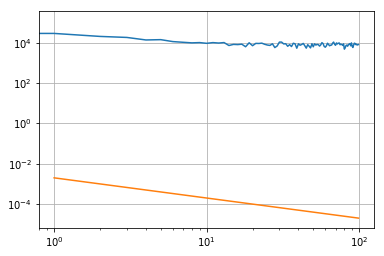

In [25]:
diff_obj_per_itter_pos = [-(x-obj_true) for x in obj_per_itter]
approx_run_time = [1/(k*500) for k in list(range(1,int(K/500)))]
plt.plot(list(range(0,int(K/500))),diff_obj_per_itter_pos)
plt.plot(list(range(1,int(K/500))),approx_run_time)
plt.loglog()
plt.grid()

In [ ]:
Gen.Save_graph_to_file("Infered_network.txt",G_star)

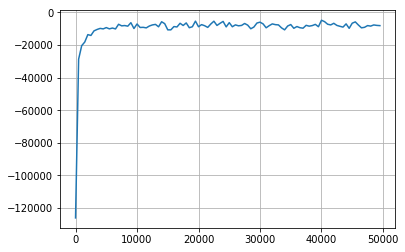

In [26]:
relative_obj_ftc = [x-obj_true for x in obj_per_itter]
x_axis = [x*500 for x in list(range(0,int(K/500)))]
plt.plot(x_axis, relative_obj_ftc)
plt.grid()
plt.show()

In [27]:
'''
# Sanity check. Compare the cvx objective value with alpha_opt and my objective function code with the same alpha

# Sanity check passed
# '''
# matrix_list,nb_casc_node = cvx.Create_matrices(G_true,DAG_C_dic,window)
# A_cvx,obj_cvx = cvx.Infer_Network_edges(G_true,matrix_list,nb_casc_node,DAG_C_dic)
# obj_maison = Infered_objective_value(A_cvx,G_star,DAG_C_dicG_C_dic,window,eps)
# print("obj my code is : ",obj_maison)
# print(obj_cvx)

'\n# Sanity check. Compare the cvx objective value with alpha_opt and my objective function code with the same alpha\n\n# Sanity check passed\n# '